# BLEU, Perplexity, and ROUGE Evaluation on Generated Texts

This notebook calculates standard NLP metrics (BLEU, Perplexity, ROUGE) on generated texts stored in JSON files from the LLM evaluation pipeline.

In [54]:
import json
import sys
from pathlib import Path
import numpy as np
from typing import Dict, List, Tuple

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")
print(f"Working directory: {Path.cwd()}")

Project root: c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen
Working directory: c:\Users\hayk_\OneDrive\Desktop\05_LMU_Masters\04_applied_dl\adl-bnn-textgen\src\evaluation


In [55]:
# Import evaluation libraries
try:
    import evaluate as hf_evaluate
    print("HuggingFace evaluate library loaded")
except ImportError:
    print("HuggingFace evaluate library not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "evaluate"])
    import evaluate as hf_evaluate
    print("HuggingFace evaluate library installed and loaded")

# Load metrics
try:
    bleu_metric = hf_evaluate.load('bleu')
    rouge_metric = hf_evaluate.load('rouge')
    perplexity_metric = hf_evaluate.load('perplexity', module_type='metric')
    print("All metrics loaded successfully")
except Exception as e:
    print(f"Error loading metrics: {e}")
    raise

HuggingFace evaluate library loaded
All metrics loaded successfully
All metrics loaded successfully


## Load Generated Texts from JSON

In [56]:
# Path to the generation results JSON
json_path = Path("llm_results/internal_data/with_scores.json")

if not json_path.exists():
    raise FileNotFoundError(f"File not found: {json_path.absolute()}")

print(f"Found file: {json_path}")

# Load the JSON data
with open(json_path, 'r') as f:
    generation_results = json.load(f)

print(f"\nLoaded {len(generation_results)} generation samples")

# Show sample structure
sample_id = list(generation_results.keys())[0]
sample_data = generation_results[sample_id]
print(f"\nSample structure (ID: {sample_id}):")
print(f"  Keys: {list(sample_data.keys())}")
print(f"  Prompt: {sample_data['prompt'][:50]}...")
print(f"  Model path: {sample_data.get('model_path', 'N/A')}")
if 'generated_text' in sample_data:
    print(f"  Generated text length: {len(sample_data['generated_text'])} chars")

Found file: llm_results\internal_data\with_scores.json

Loaded 140 generation samples

Sample structure (ID: 618022b8-3272-43fb-b6e8-b8ef7027eaa7):
  Keys: ['model_path', 'model_type', 'prompt', 'prompt_source', 'temperature', 'top_k', 'num_samples', 'generated_text', 'uncertainty_info', 'quality_score', 'diversity_score', 'relevance_score', 'brief_reasoning']
  Prompt: You were kneel'd to and impor...
  Model path: checkpoints\baseline\baseline_model_2k.pt
  Generated text length: 629 chars


## Load Reference Data (Ground Truth)

For proper BLEU and ROUGE evaluation, we need reference texts. We'll use the Shakespeare dataset as reference.

In [57]:
# Load reference data from validation set
data_dir = project_root / "notebooks" / "nanogpt" / "data" / "shakespeare_char"
val_data_path = data_dir / "val.bin"
if not val_data_path.exists():
    raise FileNotFoundError(f"Validation data not found at: {val_data_path}")

# Load tokenizer
meta_path = project_root / "checkpoints" / "baseline_nanogpt" / "meta.pkl"

if not meta_path.exists():
    raise FileNotFoundError(f"Meta file not found at: {meta_path}")

import pickle
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s if c in stoi]
decode = lambda l: ''.join([itos[i] for i in l])

# Load validation data
val_data = np.memmap(str(val_data_path), dtype=np.uint16, mode='r')
print(f"Loaded validation data: {len(val_data)} tokens")
print(f"Vocabulary size: {len(itos)}")

# Load train data  
train_data_path = data_dir / "train.bin"
train_data = np.memmap(str(train_data_path), dtype=np.uint16, mode='r')
print(f"Loaded train data: {len(train_data)} tokens")

Loaded validation data: 111540 tokens
Vocabulary size: 65
Loaded train data: 1003854 tokens


## Helper Functions for Metrics Calculation

In [58]:
def get_tokenizer(stoi):
    """Get custom tokenizer for character-level text"""
    def custom_tokenizer(text: str) -> List[str]:
        return [ch for ch in text if ch in stoi]
    return custom_tokenizer

def find_prompt_in_data(prompt: str, data, encode_fn, decode_fn, max_search_positions=1000000):
    """
    Search for the prompt in the data and return the position where it's found.
    
    Returns the index where the prompt ends (start of continuation), or None if not found.
    """
    # Encode the prompt
    prompt_tokens = encode_fn(prompt)
    
    if not prompt_tokens:
        return None
    
    prompt_len = len(prompt_tokens)
    
    # Search through the data
    search_limit = min(len(data) - prompt_len - 100, max_search_positions)
    
    # Convert to numpy array for faster comparison
    data_array = np.array(data[:search_limit + prompt_len])
    prompt_array = np.array(prompt_tokens)
    
    # Search with sliding window
    for i in range(0, search_limit):
        if i + prompt_len >= len(data_array):
            break
            
        # Check if tokens match using numpy comparison
        if np.array_equal(data_array[i:i + prompt_len], prompt_array):
            return i + prompt_len
    
    return None

def extract_references_for_prompts(prompts: List[str], train_data, val_data, encode_fn, decode_fn, generation_length=100):
    """
    Extract reference continuations from train or validation data for given prompts.
    
    Searches for each prompt in train data first, then validation data, and extracts the following text as reference.
    Returns both references and the indices of prompts that were successfully found.
    """
    references = []
    found_indices = []
    not_found_prompts = []
    
    for idx, prompt in enumerate(prompts):
        # Search for prompt in train data first
        continuation_start = find_prompt_in_data(prompt, train_data, encode_fn, decode_fn, max_search_positions=500000)
        data_source = train_data
        
        # If not found in train, try validation
        if continuation_start is None:
            continuation_start = find_prompt_in_data(prompt, val_data, encode_fn, decode_fn, max_search_positions=500000)
            data_source = val_data
        
        if continuation_start is None:
            not_found_prompts.append(prompt)
            continue
        
        # Extract continuation
        if continuation_start + generation_length <= len(data_source):
            ref_tokens = data_source[continuation_start:continuation_start + generation_length]
            reference_text = decode_fn(ref_tokens.tolist()).strip()
            references.append(reference_text)
            found_indices.append(idx)
        else:
            # Not enough data after prompt
            not_found_prompts.append(prompt)
    
    if not_found_prompts:
        print(f"Warning: {len(not_found_prompts)} prompts not found in train or validation data:")
        for p in not_found_prompts[:3]:
            print(f"  - '{p[:50]}...'")
        if len(not_found_prompts) > 3:
            print(f"  ... and {len(not_found_prompts) - 3} more")
    
    if not references:
        raise ValueError("No references could be extracted. None of the prompts were found in train or validation data.")
    
    return references, found_indices

def calculate_bleu_score(references: List[str], predictions: List[str], tokenizer):
    """Calculate BLEU score"""
    if not references or not predictions:
        raise ValueError(f"Cannot calculate BLEU: references={len(references)}, predictions={len(predictions)}")
    
    if len(references) != len(predictions):
        raise ValueError(f"Mismatch: {len(references)} references vs {len(predictions)} predictions")
    
    formatted_refs = [[r] for r in references]
    result = bleu_metric.compute(
        predictions=predictions,
        references=formatted_refs,
        tokenizer=tokenizer
    )
    return float(result.get('bleu', 0.0))

def calculate_rouge_scores(references: List[str], predictions: List[str], tokenizer):
    """Calculate ROUGE scores"""
    if not references or not predictions:
        raise ValueError(f"Cannot calculate ROUGE: references={len(references)}, predictions={len(predictions)}")
    
    if len(references) != len(predictions):
        raise ValueError(f"Mismatch: {len(references)} references vs {len(predictions)} predictions")
    
    result = rouge_metric.compute(
        predictions=predictions,
        references=references,
        tokenizer=tokenizer
    )
    return {
        'rouge1': float(result.get('rouge1', 0.0)),
        'rouge2': float(result.get('rouge2', 0.0)),
        'rougeL': float(result.get('rougeL', 0.0)),
    }

def calculate_perplexity(texts: List[str]):
    """Calculate perplexity using HuggingFace metric"""
    if not texts:
        raise ValueError("Cannot calculate perplexity: no texts provided")
    
    result = perplexity_metric.compute(
        predictions=texts,
        model_id='gpt2'
    )
    return float(result.get('mean_perplexity', None))

print("Helper functions defined")

Helper functions defined


In [ ]:
extract_references_for_prompts

## Organize Data by Model and Parameters

In [74]:
# Group generations by model and parameters
from collections import defaultdict

grouped_data = defaultdict(list)

for sample_id, data in generation_results.items():
    model_path = data.get('model_path', 'unknown')
    temperature = data.get('temperature', 'unknown')
    top_k = data.get('top_k', 'unknown')
    num_samples = data.get('num_samples', 'unknown')
    prompt_source = data.get('prompt_source', 'unknown')
    
    run_name = Path(model_path).parent.name if model_path != 'unknown' else 'unknown'
    model_name = Path(model_path).name.removesuffix("_model.pt") if model_path != 'unknown' else 'unknown'
    
    if "baseline_model_2k.pt" in model_name:
        model_name = "baseline"
    elif model_name.endswith(".pt"):
        model_name = model_name.removesuffix(".pt")
    
    # Create a key for grouping
    group_key = f"{model_name}_temp{temperature}_topk{top_k}_samples{num_samples}_{run_name}"
    
    grouped_data[group_key].append({
        'id': sample_id,
        'prompt': data.get('prompt', ''),
        'prompt_source': prompt_source,
        'generated_text': data.get('generated_text', ''),
        'model_path': model_path,
        "model_name": model_name,
        'temperature': temperature,
        'top_k': top_k,
        'num_samples': num_samples
    })

print(f"Found {len(grouped_data)} unique configurations:")
for key, items in list(grouped_data.items())[:5]:
    train_count = sum(1 for item in items if item['prompt_source'] == 'train')
    val_count = sum(1 for item in items if item['prompt_source'] == 'val')

    print(f"  {key}: {len(items)} samples (train: {train_count}, val: {val_count})")

Found 14 unique configurations:
  baseline_temp0.8_topk10_samples10_baseline: 10 samples (train: 5, val: 5)
  baseline_temp0.3_topk10_samples10_baseline: 10 samples (train: 5, val: 5)
  baoa_temp0.3_topk20_samples10_run_20251118-124935: 10 samples (train: 5, val: 5)
  baoa_temp0.3_topk10_samples10_run_20251118-124935: 10 samples (train: 5, val: 5)
  baoa_temp0.3_topk50_samples10_run_20251118-124935: 10 samples (train: 5, val: 5)


## Test: Find Continuations for Sample Prompts

Let's test the prompt search functionality with actual prompts from the generation results.

## Verification Test: Ensure Search Function Works Correctly

Let's verify the search function by extracting a known substring from the data and confirming we can find it.

In [61]:
# # VERIFICATION TEST: Extract a known substring from the data and verify we can find it
# print("="*80)
# print("VERIFICATION TEST: Testing search function accuracy")
# print("="*80)

# # Test 1: Extract a substring from a known position in train data
# test_position_1 = 1000
# test_length_1 = 20
# test_tokens_1 = train_data[test_position_1:test_position_1 + test_length_1]
# test_prompt_1 = decode(test_tokens_1.tolist())

# print(f"\nTest 1: Search for substring from train data position {test_position_1}")
# print(f"  Test prompt: '{test_prompt_1}'")

# # Search for it
# found_pos_1 = find_prompt_in_data(test_prompt_1, train_data, encode, decode, max_search_positions=500000)

# if found_pos_1 == test_position_1 + test_length_1:
#     print(f"  Result: SUCCESS - Found at expected position {found_pos_1}")
# elif found_pos_1 is not None:
#     print(f"  Result: FOUND at position {found_pos_1}, but expected {test_position_1 + test_length_1}")
#     print(f"  Position difference: {found_pos_1 - (test_position_1 + test_length_1)}")
# else:
#     print(f"  Result: FAILED - Not found!")

# # Test 2: Extract a different substring from validation data
# test_position_2 = 5000
# test_length_2 = 15
# test_tokens_2 = val_data[test_position_2:test_position_2 + test_length_2]
# test_prompt_2 = decode(test_tokens_2.tolist())

# print(f"\nTest 2: Search for substring from validation data position {test_position_2}")
# print(f"  Test prompt: '{test_prompt_2}'")

# # Search for it
# found_pos_2 = find_prompt_in_data(test_prompt_2, val_data, encode, decode, max_search_positions=500000)

# if found_pos_2 == test_position_2 + test_length_2:
#     print(f"  Result: SUCCESS - Found at expected position {found_pos_2}")
# elif found_pos_2 is not None:
#     print(f"  Result: FOUND at position {found_pos_2}, but expected {test_position_2 + test_length_2}")
#     print(f"  Position difference: {found_pos_2 - (test_position_2 + test_length_2)}")
# else:
#     print(f"  Result: FAILED - Not found!")

# # Test 3: Test a longer substring from train data
# test_position_3 = 10000
# test_length_3 = 30
# test_tokens_3 = train_data[test_position_3:test_position_3 + test_length_3]
# test_prompt_3 = decode(test_tokens_3.tolist())

# print(f"\nTest 3: Search for longer substring (30 chars) from train data position {test_position_3}")
# print(f"  Test prompt: '{test_prompt_3}'")

# # Search for it
# found_pos_3 = find_prompt_in_data(test_prompt_3, train_data, encode, decode, max_search_positions=500000)

# if found_pos_3 == test_position_3 + test_length_3:
#     print(f"  Result: SUCCESS - Found at expected position {found_pos_3}")
# elif found_pos_3 is not None:
#     print(f"  Result: FOUND at position {found_pos_3}, but expected {test_position_3 + test_length_3}")
#     print(f"  Position difference: {found_pos_3 - (test_position_3 + test_length_3)}")
#     # Check if the substring actually appears multiple times
#     if found_pos_3 < test_position_3 + test_length_3:
#         print(f"  Note: Found an earlier occurrence of the same substring")
# else:
#     print(f"  Result: FAILED - Not found!")

# # Test 4: Verify the continuation after finding the prompt
# if found_pos_1 is not None:
#     print(f"\nTest 4: Verify continuation extraction works correctly")
#     continuation_tokens = train_data[found_pos_1:found_pos_1 + 50]
#     continuation = decode(continuation_tokens.tolist())
#     print(f"  Continuation after found position: '{continuation}'")
    
#     # Verify this is actually what comes after in the original data
#     expected_continuation_tokens = train_data[test_position_1 + test_length_1:test_position_1 + test_length_1 + 50]
#     expected_continuation = decode(expected_continuation_tokens.tolist())
    
#     if continuation == expected_continuation:
#         print(f"  Result: SUCCESS - Continuation matches expected text")
#     else:
#         print(f"  Result: MISMATCH")
#         print(f"  Expected: '{expected_continuation}'")

# print(f"\n{'='*80}")
# print("VERIFICATION COMPLETE")
# print('='*80)

## Test: Search for Known Shakespeare Prompts

Let's test with prompts that we know are in the training data.

In [62]:
# # Test with prompts extracted from the actual training data
# print("="*80)
# print("Testing with prompts from Shakespeare training data")
# print("="*80)

# # Get some prompts from the training data itself
# test_prompts_shakespeare = [
#     "you know Caius",  # This should be in the data based on Test 4 output
#     "Second Citizen:",  # From Test 1
#     "Win upon power",  # From Test 3
# ]

# found_shakespeare = {}
# not_found_shakespeare = []

# for prompt in test_prompts_shakespeare:
#     print(f"\nPrompt: '{prompt}'")
    
#     # Search in train data first
#     continuation_start = find_prompt_in_data(prompt, train_data, encode, decode, max_search_positions=len(train_data))
#     data_source = "train"
#     data_array = train_data
    
#     # If not found in train, try validation
#     if continuation_start is None:
#         continuation_start = find_prompt_in_data(prompt, val_data, encode, decode, max_search_positions=len(val_data))
#         data_source = "validation"
#         data_array = val_data
    
#     if continuation_start is not None:
#         # Extract continuation
#         continuation_length = 100
#         if continuation_start + continuation_length <= len(data_array):
#             continuation_tokens = data_array[continuation_start:continuation_start + continuation_length]
#             continuation_text = decode(continuation_tokens.tolist())
#             found_shakespeare[prompt] = {
#                 'text': continuation_text,
#                 'source': data_source,
#                 'position': continuation_start
#             }
            
#             print(f"  Status: FOUND in {data_source} data at position {continuation_start}")
#             print(f"  Continuation: '{continuation_text[:80]}...'")
#         else:
#             print(f"  Status: FOUND in {data_source} but not enough data for continuation")
#             not_found_shakespeare.append(prompt)
#     else:
#         print(f"  Status: NOT FOUND in either train or validation data")
#         not_found_shakespeare.append(prompt)

# print(f"\n{'='*80}")
# print("SUMMARY")
# print('='*80)
# print(f"Total prompts tested: {len(test_prompts_shakespeare)}")
# print(f"Found: {len(found_shakespeare)}")
# print(f"Not found: {len(not_found_shakespeare)}")

In [63]:
# # Display the found Shakespeare prompt-continuation pairs
# if found_shakespeare:
#     print(f"\n{'='*80}")
#     print(f"SHAKESPEARE PROMPT-CONTINUATION EXAMPLES")
#     print('='*80)
    
#     for i, (prompt, info) in enumerate(found_shakespeare.items(), 1):
#         continuation = info['text']
#         source = info['source']
#         position = info['position']
        
#         print(f"\nExample {i}:")
#         print(f"-" * 80)
#         print(f"PROMPT: '{prompt}'")
#         print(f"\nCONTINUATION (from {source} data, position {position}):")
#         print(f"{continuation}")
#         print(f"-" * 80)

## Extract Random Meaningful Prompts from Training Data

Extract random meaningful start prompts from the training and validation data for evaluation.

In [64]:
# import random
# import re
# from datetime import datetime

# def extract_meaningful_prompts(data, decode_fn, num_prompts=10, min_length=15, max_length=50):
#     """
#     Extract random meaningful prompts from the data.
    
#     Looks for text that starts after common punctuation marks (sentence boundaries)
#     and has reasonable length.
#     """
#     prompts = []
#     attempts = 0
#     max_attempts = num_prompts * 100
    
#     # Define patterns that indicate good starting points (after punctuation + newline/space)
#     while len(prompts) < num_prompts and attempts < max_attempts:
#         attempts += 1
        
#         # Random starting position (avoid the very end)
#         start_pos = random.randint(0, len(data) - max_length - 100)
        
#         # Decode a chunk to analyze
#         chunk_tokens = data[start_pos:start_pos + max_length + 20]
#         chunk_text = decode_fn(chunk_tokens.tolist())
        
#         # Look for good starting points: after .\n, ?\n, !\n, or after character names (ending with :)
#         # Also accept start of speeches after newlines
#         matches = list(re.finditer(r'(?:[.!?]\n|:\n)([A-Z][^.!?\n]{' + str(min_length) + r',' + str(max_length) + r'})', chunk_text))
        
#         if matches:
#             # Pick the first good match
#             match = matches[0]
#             prompt_text = match.group(1).strip()
            
#             # Ensure it's not too similar to existing prompts
#             if prompt_text and not any(prompt_text[:20] in p[:20] for p in prompts):
#                 prompts.append(prompt_text)
                
#     return prompts

# # Extract prompts from train data
# print("Extracting 10 random meaningful prompts from training data...")
# train_prompts = extract_meaningful_prompts(train_data, decode, num_prompts=10, min_length=20, max_length=60)

# print(f"\nExtracted {len(train_prompts)} prompts from TRAIN data:")
# print("="*80)
# for i, prompt in enumerate(train_prompts, 1):
#     print(f"{i}. '{prompt}'")

# # Extract prompts from validation data
# print(f"\n{'='*80}")
# print("Extracting 10 random meaningful prompts from validation data...")
# val_prompts = extract_meaningful_prompts(val_data, decode, num_prompts=10, min_length=20, max_length=60)

# print(f"\nExtracted {len(val_prompts)} prompts from VALIDATION data:")
# print("="*80)
# for i, prompt in enumerate(val_prompts, 1):
#     print(f"{i}. '{prompt}'")

# # Combine all prompts
# all_extracted_prompts = train_prompts + val_prompts

# # Save to JSON file
# prompts_output = {
#     'train_prompts': train_prompts,
#     'val_prompts': val_prompts,
#     'all_prompts': all_extracted_prompts,
#     'extraction_date': datetime.now().isoformat(),
#     'num_train_prompts': len(train_prompts),
#     'num_val_prompts': len(val_prompts),
#     'total_prompts': len(all_extracted_prompts)
# }

# prompts_json_path = Path("extracted_prompts.json")
# with open(prompts_json_path, 'w', encoding='utf-8') as f:
#     json.dump(prompts_output, f, indent=2, ensure_ascii=False)

# print(f"\n{'='*80}")
# print(f"Saved {len(all_extracted_prompts)} prompts to: {prompts_json_path.absolute()}")
# print("="*80)

In [65]:
# # Get unique prompts from the generation results
# unique_prompts = set()
# for sample_id, data in generation_results.items():
#     prompt = data.get('prompt', '')
#     if prompt:
#         unique_prompts.add(prompt)

# unique_prompts.add("you know Caius")

# unique_prompts = sorted(list(unique_prompts))
# print(f"Found {len(unique_prompts)} unique prompts in generation results:\n")

# for i, prompt in enumerate(unique_prompts, 1):
#     print(f"{i}. '{prompt}'")

# print(f"\n{'='*80}")
# print("Searching for these prompts in train and validation data...")
# print('='*80)

# # Test finding each prompt in both datasets
# found_continuations = {}
# not_found_prompts = []

# for prompt in unique_prompts:
#     print(f"\nPrompt: '{prompt}'")
    
#     # Search in train data first
#     continuation_start = find_prompt_in_data(prompt, train_data, encode, decode, max_search_positions=500000)
#     data_source = "train"
#     data_array = train_data
    
#     # If not found in train, try validation
#     if continuation_start is None:
#         continuation_start = find_prompt_in_data(prompt, val_data, encode, decode, max_search_positions=500000)
#         data_source = "validation"
#         data_array = val_data
    
#     if continuation_start is not None:
#         # Extract continuation
#         continuation_length = 200  # characters
#         if continuation_start + continuation_length <= len(data_array):
#             continuation_tokens = data_array[continuation_start:continuation_start + continuation_length]
#             continuation_text = decode(continuation_tokens.tolist())
#             found_continuations[prompt] = {
#                 'text': continuation_text,
#                 'source': data_source,
#                 'position': continuation_start
#             }
            
#             print(f"  Status: FOUND in {data_source} data at position {continuation_start}")
#             print(f"  Continuation preview: '{continuation_text[:100]}...'")
#         else:
#             print(f"  Status: FOUND in {data_source} but not enough data for continuation")
#             not_found_prompts.append(prompt)
#     else:
#         print(f"  Status: NOT FOUND in either train or validation data")
#         not_found_prompts.append(prompt)

# print(f"\n{'='*80}")
# print("SUMMARY")
# print('='*80)
# print(f"Total prompts: {len(unique_prompts)}")
# print(f"Found with continuation: {len(found_continuations)}")
# print(f"Not found or insufficient data: {len(not_found_prompts)}")

# # Count by source
# train_count = sum(1 for v in found_continuations.values() if v['source'] == 'train')
# val_count = sum(1 for v in found_continuations.values() if v['source'] == 'validation')
# print(f"\nFound in train data: {train_count}")
# print(f"Found in validation data: {val_count}")

# if not_found_prompts:
#     print(f"\nPrompts not found:")
#     for p in not_found_prompts:
#         print(f"  - '{p}'")

In [66]:
# # please print the texts from train.bin
# data_dir = project_root / "notebooks" / "nanogpt" / "data" / "shakespeare_char"
# train_data_path = data_dir / "val.bin"

# if not train_data_path.exists():
#     raise FileNotFoundError(f"Train data not found at: {train_data_path}")

# import numpy as np
# train_data = np.memmap(str(train_data_path), dtype=np.uint16, mode='r')
# print(f"Loaded train data: {len(train_data)} tokens")

# # Display first 500 characters from train data
# train_text = decode(train_data.tolist())
# print(f"\nFirst 500 characters from train data:\n{train_text}")

# # please save all to a text file called train_data_excerpt.txt
# excerpt_path = Path("val_data_excerpt.txt")
# with open(excerpt_path, "w", encoding="utf-8") as f:
#     f.write(train_text)

## Display Example Prompt-Continuation Pairs

Show a few examples of found prompt-continuation pairs for inspection.

In [67]:
# # Display examples of prompt-continuation pairs
# num_examples = min(3, len(found_continuations))

# if found_continuations:
#     print(f"{'='*80}")
#     print(f"EXAMPLE PROMPT-CONTINUATION PAIRS")
#     print('='*80)
    
#     for i, (prompt, info) in enumerate(list(found_continuations.items())[:num_examples], 1):
#         continuation = info['text']
#         source = info['source']
#         position = info['position']
        
#         print(f"\nExample {i}:")
#         print(f"-" * 80)
#         print(f"PROMPT:")
#         print(f"  '{prompt}'")
#         print(f"\nGROUND TRUTH CONTINUATION (from {source} data, position {position}):")
#         print(f"  '{continuation[:150]}{'...' if len(continuation) > 150 else ''}'")
#         print(f"-" * 80)
# else:
#     print("No prompt-continuation pairs found!")

## Calculate Metrics for Each Configuration

In [68]:
from tqdm import tqdm

In [75]:
results_summary = {}

# Get tokenizer
tokenizer = get_tokenizer(stoi)

print("Calculating metrics for each configuration...\n")

# Extract all unique prompts and their references ONCE at the beginning
print("Step 1: Extracting references for all unique prompts...")
all_unique_prompts = set()
for samples in grouped_data.values():
    for s in samples:
        if s['generated_text']:
            all_unique_prompts.add(s['prompt'])

all_unique_prompts = list(all_unique_prompts)
print(f"  Found {len(all_unique_prompts)} unique prompts")

# Extract references for all unique prompts
try:
    all_references, all_found_indices = extract_references_for_prompts(
        all_unique_prompts,
        train_data,
        val_data,
        encode,
        decode,
        generation_length=1000
    )
    
    # Create a mapping from prompt to reference
    prompt_to_reference = {}
    for idx in all_found_indices:
        prompt_to_reference[all_unique_prompts[idx]] = all_references[all_found_indices.index(idx)]
    
    print(f"  Successfully extracted references for {len(prompt_to_reference)} prompts\n")
except Exception as e:
    print(f"  Error extracting references: {e}")
    prompt_to_reference = {}

print("Step 2: Calculating metrics for each configuration...\n")

for config_key, samples in tqdm(grouped_data.items()):
    print(f"Processing: {config_key} ({len(samples)} samples)")
    
    # Separate samples by prompt source
    train_samples = [s for s in samples if s.get('prompt_source') == 'train' and s['generated_text']]
    val_samples = [s for s in samples if s.get('prompt_source') == 'val' and s['generated_text']]
    all_samples = [s for s in samples if s['generated_text']]
    
    if not all_samples:
        print(f"  No valid predictions found, skipping\n")
        continue
    
    print(f"  Train samples: {len(train_samples)}, Val samples: {len(val_samples)}")
    
    # Function to calculate metrics for a subset of samples
    def calculate_metrics_for_samples(sample_list, subset_name):
        if not sample_list:
            return None
        
        # Filter samples to only those with available references
        filtered_samples = [s for s in sample_list if s['prompt'] in prompt_to_reference]
        
        if not filtered_samples:
            print(f"  No references found for {subset_name} samples")
            return None
        
        predictions = [s['generated_text'] for s in filtered_samples]
        references = [prompt_to_reference[s['prompt']] for s in filtered_samples]
        
        if len(predictions) != len(references):
            print(f"  Error: Mismatch - {len(references)} references vs {len(predictions)} predictions")
            return None
        
        # Calculate metrics
        try:
            bleu_score = calculate_bleu_score(references, predictions, tokenizer)
            rouge_scores = calculate_rouge_scores(references, predictions, tokenizer)
            perplexity = calculate_perplexity(predictions)
            
            return {
                'num_samples': len(filtered_samples),
                'num_prompts_not_found': len(sample_list) - len(filtered_samples),
                'bleu': bleu_score,
                'rouge1': rouge_scores['rouge1'],
                'rouge2': rouge_scores['rouge2'],
                'rougeL': rouge_scores['rougeL'],
                'perplexity': perplexity,
                'avg_text_length': np.mean([len(p) for p in predictions])
            }
        except Exception as e:
            print(f"  Error calculating metrics for {subset_name}: {e}")
            return None
    
    # Calculate overall metrics
    overall_metrics = calculate_metrics_for_samples(all_samples, "overall")
    
    # Calculate train-specific metrics
    train_metrics = calculate_metrics_for_samples(train_samples, "train") if train_samples else None
    
    # Calculate val-specific metrics
    val_metrics = calculate_metrics_for_samples(val_samples, "val") if val_samples else None
    
    if overall_metrics is None:
        print(f"  Skipping this configuration due to errors\n")
        continue
    
    # Store results
    results_summary[config_key] = {
        'model_path': samples[0]['model_path'],
        "model_name": samples[0]['model_name'],
        'temperature': samples[0]['temperature'],
        'top_k': samples[0]['top_k'],
        'overall': overall_metrics,
        'train': train_metrics,
        'val': val_metrics
    }
    
    # Print overall metrics
    print(f"  Overall - BLEU: {overall_metrics['bleu']:.4f}, ROUGE-1: {overall_metrics['rouge1']:.4f}, "
          f"ROUGE-L: {overall_metrics['rougeL']:.4f}, Perplexity: {overall_metrics['perplexity']:.2f}")
    if overall_metrics['num_prompts_not_found'] > 0:
        print(f"           ({overall_metrics['num_prompts_not_found']} prompts excluded - not found in data)")
    
    # Print train metrics if available
    if train_metrics:
        print(f"  Train   - BLEU: {train_metrics['bleu']:.4f}, ROUGE-1: {train_metrics['rouge1']:.4f}, "
              f"ROUGE-L: {train_metrics['rougeL']:.4f}, Perplexity: {train_metrics['perplexity']:.2f}")
        if train_metrics['num_prompts_not_found'] > 0:
            print(f"           ({train_metrics['num_prompts_not_found']} prompts excluded - not found in data)")
    
    # Print val metrics if available
    if val_metrics:
        print(f"  Val     - BLEU: {val_metrics['bleu']:.4f}, ROUGE-1: {val_metrics['rouge1']:.4f}, "
              f"ROUGE-L: {val_metrics['rougeL']:.4f}, Perplexity: {val_metrics['perplexity']:.2f}")
        if val_metrics['num_prompts_not_found'] > 0:
            print(f"           ({val_metrics['num_prompts_not_found']} prompts excluded - not found in data)")
    
    print()

print(f"Completed metrics calculation for {len(results_summary)} configurations")


Calculating metrics for each configuration...

Step 1: Extracting references for all unique prompts...
  Found 10 unique prompts
  - 'Far be the thought of this from Henry's heart,...'
  Successfully extracted references for 9 prompts

Step 2: Calculating metrics for each configuration...

  - 'Far be the thought of this from Henry's heart,...'
  Successfully extracted references for 9 prompts

Step 2: Calculating metrics for each configuration...



  0%|          | 0/14 [00:00<?, ?it/s]

Processing: baseline_temp0.8_topk10_samples10_baseline (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:33<07:12, 33.30s/it]

  Overall - BLEU: 0.2663, ROUGE-1: 0.7511, ROUGE-L: 0.3790, Perplexity: 154.23
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2695, ROUGE-1: 0.7538, ROUGE-L: 0.3794, Perplexity: 188.24
  Val     - BLEU: 0.2622, ROUGE-1: 0.7476, ROUGE-L: 0.3783, Perplexity: 111.72
           (1 prompts excluded - not found in data)

Processing: baseline_temp0.3_topk10_samples10_baseline (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:58<05:44, 28.69s/it]

  Overall - BLEU: 0.2478, ROUGE-1: 0.7367, ROUGE-L: 0.3905, Perplexity: 55.56
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2405, ROUGE-1: 0.7349, ROUGE-L: 0.3852, Perplexity: 62.45
  Val     - BLEU: 0.2567, ROUGE-1: 0.7372, ROUGE-L: 0.3964, Perplexity: 46.93
           (1 prompts excluded - not found in data)

Processing: baoa_temp0.3_topk20_samples10_run_20251118-124935 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [01:25<05:04, 27.70s/it]

  Overall - BLEU: 0.2445, ROUGE-1: 0.7412, ROUGE-L: 0.3868, Perplexity: 60.93
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2379, ROUGE-1: 0.7443, ROUGE-L: 0.3885, Perplexity: 60.77
  Val     - BLEU: 0.2523, ROUGE-1: 0.7369, ROUGE-L: 0.3837, Perplexity: 61.13
           (1 prompts excluded - not found in data)

Processing: baoa_temp0.3_topk10_samples10_run_20251118-124935 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [01:49<04:23, 26.33s/it]

  Overall - BLEU: 0.2362, ROUGE-1: 0.7278, ROUGE-L: 0.3871, Perplexity: 59.01
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2340, ROUGE-1: 0.7442, ROUGE-L: 0.3954, Perplexity: 74.57
  Val     - BLEU: 0.2386, ROUGE-1: 0.7066, ROUGE-L: 0.3772, Perplexity: 39.57
           (1 prompts excluded - not found in data)

Processing: baoa_temp0.3_topk50_samples10_run_20251118-124935 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [02:13<03:50, 25.57s/it]

  Overall - BLEU: 0.2358, ROUGE-1: 0.7286, ROUGE-L: 0.3773, Perplexity: 55.18
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2369, ROUGE-1: 0.7418, ROUGE-L: 0.3848, Perplexity: 65.87
  Val     - BLEU: 0.2344, ROUGE-1: 0.7101, ROUGE-L: 0.3683, Perplexity: 41.81
           (1 prompts excluded - not found in data)

Processing: baoa_temp0.8_topk10_samples10_run_20251118-124935 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 6/14 [02:37<03:20, 25.11s/it]

  Overall - BLEU: 0.2680, ROUGE-1: 0.7543, ROUGE-L: 0.3776, Perplexity: 163.07
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2651, ROUGE-1: 0.7549, ROUGE-L: 0.3737, Perplexity: 187.99
  Val     - BLEU: 0.2716, ROUGE-1: 0.7540, ROUGE-L: 0.3821, Perplexity: 131.91
           (1 prompts excluded - not found in data)

Processing: baoa_temp0.8_topk50_samples10_run_20251118-124935 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 7/14 [03:03<02:56, 25.14s/it]

  Overall - BLEU: 0.2590, ROUGE-1: 0.7427, ROUGE-L: 0.3710, Perplexity: 194.11
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2538, ROUGE-1: 0.7358, ROUGE-L: 0.3655, Perplexity: 155.47
  Val     - BLEU: 0.2653, ROUGE-1: 0.7510, ROUGE-L: 0.3781, Perplexity: 242.39
           (1 prompts excluded - not found in data)

Processing: baoa_temp0.8_topk20_samples10_run_20251118-124935 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 8/14 [03:29<02:33, 25.56s/it]

  Overall - BLEU: 0.2704, ROUGE-1: 0.7523, ROUGE-L: 0.3813, Perplexity: 174.37
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2641, ROUGE-1: 0.7521, ROUGE-L: 0.3795, Perplexity: 156.50
  Val     - BLEU: 0.2778, ROUGE-1: 0.7522, ROUGE-L: 0.3833, Perplexity: 196.70
           (1 prompts excluded - not found in data)

Processing: sghmc_temp0.3_topk20_samples10_run_20251119-120219 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 9/14 [03:54<02:06, 25.37s/it]

  Overall - BLEU: 0.2360, ROUGE-1: 0.7240, ROUGE-L: 0.3827, Perplexity: 100.15
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2412, ROUGE-1: 0.7396, ROUGE-L: 0.3843, Perplexity: 116.29
  Val     - BLEU: 0.2296, ROUGE-1: 0.7032, ROUGE-L: 0.3791, Perplexity: 79.97
           (1 prompts excluded - not found in data)

Processing: sghmc_temp0.3_topk50_samples10_run_20251119-120219 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 10/14 [04:20<01:41, 25.43s/it]

  Overall - BLEU: 0.2315, ROUGE-1: 0.7197, ROUGE-L: 0.3804, Perplexity: 90.57
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2346, ROUGE-1: 0.7299, ROUGE-L: 0.3783, Perplexity: 93.65
  Val     - BLEU: 0.2276, ROUGE-1: 0.7071, ROUGE-L: 0.3830, Perplexity: 86.72
           (1 prompts excluded - not found in data)

Processing: sghmc_temp0.3_topk10_samples10_run_20251119-120219 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 11/14 [04:44<01:15, 25.24s/it]

  Overall - BLEU: 0.2400, ROUGE-1: 0.7293, ROUGE-L: 0.3795, Perplexity: 95.68
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2354, ROUGE-1: 0.7343, ROUGE-L: 0.3780, Perplexity: 107.20
  Val     - BLEU: 0.2456, ROUGE-1: 0.7224, ROUGE-L: 0.3812, Perplexity: 81.27
           (1 prompts excluded - not found in data)

Processing: sghmc_temp0.8_topk50_samples10_run_20251119-120219 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 12/14 [05:10<00:50, 25.22s/it]

  Overall - BLEU: 0.2656, ROUGE-1: 0.7548, ROUGE-L: 0.3815, Perplexity: 296.70
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2651, ROUGE-1: 0.7581, ROUGE-L: 0.3790, Perplexity: 273.61
  Val     - BLEU: 0.2661, ROUGE-1: 0.7507, ROUGE-L: 0.3842, Perplexity: 325.57
           (1 prompts excluded - not found in data)

Processing: sghmc_temp0.8_topk10_samples10_run_20251119-120219 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 13/14 [05:36<00:25, 25.72s/it]

  Overall - BLEU: 0.2619, ROUGE-1: 0.7520, ROUGE-L: 0.3765, Perplexity: 308.54
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2600, ROUGE-1: 0.7543, ROUGE-L: 0.3728, Perplexity: 280.82
  Val     - BLEU: 0.2643, ROUGE-1: 0.7491, ROUGE-L: 0.3809, Perplexity: 343.19
           (1 prompts excluded - not found in data)

Processing: sghmc_temp0.8_topk20_samples10_run_20251119-120219 (10 samples)
  Train samples: 5, Val samples: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 14/14 [06:11<00:00, 26.53s/it]

  Overall - BLEU: 0.2594, ROUGE-1: 0.7458, ROUGE-L: 0.3686, Perplexity: 234.20
           (1 prompts excluded - not found in data)
  Train   - BLEU: 0.2600, ROUGE-1: 0.7530, ROUGE-L: 0.3690, Perplexity: 269.72
  Val     - BLEU: 0.2585, ROUGE-1: 0.7366, ROUGE-L: 0.3677, Perplexity: 189.80
           (1 prompts excluded - not found in data)

Completed metrics calculation for 14 configurations


## Display Results as DataFrame

In [81]:
import pandas as pd

# Create DataFrames for overall, train, and val metrics
def create_df_from_results(results_dict, metric_type='overall'):
    """Create DataFrame from results for a specific metric type (overall/train/val)"""
    rows = []
    for config_key, config_data in results_dict.items():
        metrics = config_data.get(metric_type)
        if metrics is not None:
            row = {
                'config': config_key,
                'model_path': config_data['model_path'],
                'temperature': config_data['temperature'],
                'top_k': config_data['top_k'],
                **metrics
            }
            rows.append(row)
    return pd.DataFrame(rows).set_index('config')

# Create separate DataFrames
df_overall = create_df_from_results(results_summary, 'overall')
df_train = create_df_from_results(results_summary, 'train')
df_val = create_df_from_results(results_summary, 'val')

# Sort by BLEU score
if not df_overall.empty:
    df_overall = df_overall.sort_values('bleu', ascending=False)
if not df_train.empty:
    df_train = df_train.sort_values('bleu', ascending=False)
if not df_val.empty:
    df_val = df_val.sort_values('bleu', ascending=False)

# Display overall results
print("="*100)
print("OVERALL EVALUATION RESULTS")
print("="*100)
if not df_overall.empty:
    print(df_overall[['num_samples', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'perplexity', 'temperature', 'top_k']].to_string())
else:
    print("No overall results available")
print()

# Display train results
print("="*100)
print("TRAIN PROMPTS EVALUATION RESULTS")
print("="*100)
if not df_train.empty:
    print(df_train[['num_samples', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'perplexity', 'temperature', 'top_k']].to_string())
else:
    print("No train results available")
print()

# Display val results
print("="*100)
print("VALIDATION PROMPTS EVALUATION RESULTS")
print("="*100)
if not df_val.empty:
    print(df_val[['num_samples', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'perplexity', 'temperature', 'top_k']].to_string())
else:
    print("No validation results available")
print("="*100)

# Display overall DataFrame for interactive viewing
df_overall


OVERALL EVALUATION RESULTS
                                                    num_samples      bleu    rouge1    rouge2    rougeL  perplexity  temperature  top_k
config                                                                                                                                 
baoa_temp0.8_topk20_samples10_run_20251118-124935             9  0.270381  0.752328  0.560707  0.381278  174.369147          0.8     20
baoa_temp0.8_topk10_samples10_run_20251118-124935             9  0.268048  0.754268  0.557539  0.377649  163.065025          0.8     10
baseline_temp0.8_topk10_samples10_baseline                    9  0.266263  0.751094  0.549024  0.379038  154.229330          0.8     10
sghmc_temp0.8_topk50_samples10_run_20251119-120219            9  0.265576  0.754768  0.554174  0.381510  296.703805          0.8     50
sghmc_temp0.8_topk10_samples10_run_20251119-120219            9  0.261949  0.752025  0.546445  0.376498  308.537930          0.8     10
sghmc_temp0.8_topk20_

,model_path,temperature,top_k,num_samples,num_prompts_not_found,bleu,rouge1,rouge2,rougeL,perplexity,avg_text_length
config,,,,,,,,,,,
baoa_temp0.8_topk20_samples10_run_20251118-124935,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,20,9,1,0.270381,0.752328,0.560707,0.381278,174.369147,634.0
baoa_temp0.8_topk10_samples10_run_20251118-124935,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,10,9,1,0.268048,0.754268,0.557539,0.377649,163.065025,634.0
baseline_temp0.8_topk10_samples10_baseline,checkpoints\baseline\baseline_model_2k.pt,0.8,10,9,1,0.266263,0.751094,0.549024,0.379038,154.229330,634.0
sghmc_temp0.8_topk50_samples10_run_20251119-120219,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.8,50,9,1,0.265576,0.754768,0.554174,0.381510,296.703805,634.0
sghmc_temp0.8_topk10_samples10_run_20251119-120219,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.8,10,9,1,0.261949,0.752025,0.546445,0.376498,308.537930,634.0
sghmc_temp0.8_topk20_samples10_run_20251119-120219,/content/drive/MyDrive/samplers/sghmc_sampler/...,0.8,20,9,1,0.259361,0.745811,0.547168,0.368575,234.204608,634.0
baoa_temp0.8_topk50_samples10_run_20251118-124935,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.8,50,9,1,0.258955,0.742705,0.545503,0.371026,194.105507,634.0
baseline_temp0.3_topk10_samples10_baseline,checkpoints\baseline\baseline_model_2k.pt,0.3,10,9,1,0.247755,0.736737,0.498006,0.390537,55.555834,634.0
baoa_temp0.3_topk20_samples10_run_20251118-124935,/content/drive/MyDrive/samplers/baoa_sampler/r...,0.3,20,9,1,0.244476,0.741228,0.494185,0.386784,60.925895,634.0


## Group by Model: Average and Median Metrics

Display aggregate statistics grouped by model name.

In [82]:
# Group results by model name
model_grouped = {}

for config_key, config_data in results_summary.items():
    model_name = config_data['model_name']
    
    if model_name not in model_grouped:
        model_grouped[model_name] = {
            'overall': [],
            'train': [],
            'val': []
        }
    
    # Collect overall metrics
    if config_data.get('overall'):
        model_grouped[model_name]['overall'].append(config_data['overall'])
    
    # Collect train metrics
    if config_data.get('train'):
        model_grouped[model_name]['train'].append(config_data['train'])
    
    # Collect val metrics
    if config_data.get('val'):
        model_grouped[model_name]['val'].append(config_data['val'])

print(f"Found {len(model_grouped)} unique models")
print(f"Models: {list(model_grouped.keys())}")

# Calculate aggregate statistics for each model
def calculate_aggregate_stats(metrics_list):
    """Calculate mean and median for a list of metric dictionaries"""
    if not metrics_list:
        return None
    
    # Extract values for each metric
    bleu_values = [m['bleu'] for m in metrics_list]
    rouge1_values = [m['rouge1'] for m in metrics_list]
    rouge2_values = [m['rouge2'] for m in metrics_list]
    rougeL_values = [m['rougeL'] for m in metrics_list]
    perplexity_values = [m['perplexity'] for m in metrics_list]
    
    return {
        'num_configs': len(metrics_list),
        'bleu_mean': np.mean(bleu_values),
        'bleu_median': np.median(bleu_values),
        'rouge1_mean': np.mean(rouge1_values),
        'rouge1_median': np.median(rouge1_values),
        'rouge2_mean': np.mean(rouge2_values),
        'rouge2_median': np.median(rouge2_values),
        'rougeL_mean': np.mean(rougeL_values),
        'rougeL_median': np.median(rougeL_values),
        'perplexity_mean': np.mean(perplexity_values),
        'perplexity_median': np.median(perplexity_values),
    }

# Compute aggregate statistics
model_stats = {}
for model_name, metrics_dict in model_grouped.items():
    model_stats[model_name] = {
        'overall': calculate_aggregate_stats(metrics_dict['overall']),
        'train': calculate_aggregate_stats(metrics_dict['train']),
        'val': calculate_aggregate_stats(metrics_dict['val'])
    }

print("\n" + "="*120)
print("MODEL-LEVEL AGGREGATE STATISTICS")
print("="*120)

for model_name, stats in model_stats.items():
    print(f"\n### MODEL: {model_name} ###")
    
    # Overall stats
    if stats['overall']:
        overall = stats['overall']
        print(f"\nOVERALL ({overall['num_configs']} configurations):")
        print(f"  BLEU:       Mean={overall['bleu_mean']:.4f}, Median={overall['bleu_median']:.4f}")
        print(f"  ROUGE-1:    Mean={overall['rouge1_mean']:.4f}, Median={overall['rouge1_median']:.4f}")
        print(f"  ROUGE-2:    Mean={overall['rouge2_mean']:.4f}, Median={overall['rouge2_median']:.4f}")
        print(f"  ROUGE-L:    Mean={overall['rougeL_mean']:.4f}, Median={overall['rougeL_median']:.4f}")
        print(f"  Perplexity: Mean={overall['perplexity_mean']:.2f}, Median={overall['perplexity_median']:.2f}")
    
    # Train stats
    if stats['train']:
        train = stats['train']
        print(f"\nTRAIN ({train['num_configs']} configurations):")
        print(f"  BLEU:       Mean={train['bleu_mean']:.4f}, Median={train['bleu_median']:.4f}")
        print(f"  ROUGE-1:    Mean={train['rouge1_mean']:.4f}, Median={train['rouge1_median']:.4f}")
        print(f"  ROUGE-2:    Mean={train['rouge2_mean']:.4f}, Median={train['rouge2_median']:.4f}")
        print(f"  ROUGE-L:    Mean={train['rougeL_mean']:.4f}, Median={train['rougeL_median']:.4f}")
        print(f"  Perplexity: Mean={train['perplexity_mean']:.2f}, Median={train['perplexity_median']:.2f}")
    
    # Val stats
    if stats['val']:
        val = stats['val']
        print(f"\nVAL ({val['num_configs']} configurations):")
        print(f"  BLEU:       Mean={val['bleu_mean']:.4f}, Median={val['bleu_median']:.4f}")
        print(f"  ROUGE-1:    Mean={val['rouge1_mean']:.4f}, Median={val['rouge1_median']:.4f}")
        print(f"  ROUGE-2:    Mean={val['rouge2_mean']:.4f}, Median={val['rouge2_median']:.4f}")
        print(f"  ROUGE-L:    Mean={val['rougeL_mean']:.4f}, Median={val['rougeL_median']:.4f}")
        print(f"  Perplexity: Mean={val['perplexity_mean']:.2f}, Median={val['perplexity_median']:.2f}")

print("\n" + "="*120)

Found 3 unique models
Models: ['baseline', 'baoa', 'sghmc']

MODEL-LEVEL AGGREGATE STATISTICS

### MODEL: baseline ###

OVERALL (2 configurations):
  BLEU:       Mean=0.2570, Median=0.2570
  ROUGE-1:    Mean=0.7439, Median=0.7439
  ROUGE-2:    Mean=0.5235, Median=0.5235
  ROUGE-L:    Mean=0.3848, Median=0.3848
  Perplexity: Mean=104.89, Median=104.89

TRAIN (2 configurations):
  BLEU:       Mean=0.2550, Median=0.2550
  ROUGE-1:    Mean=0.7444, Median=0.7444
  ROUGE-2:    Mean=0.5166, Median=0.5166
  ROUGE-L:    Mean=0.3823, Median=0.3823
  Perplexity: Mean=125.35, Median=125.35

VAL (2 configurations):
  BLEU:       Mean=0.2594, Median=0.2594
  ROUGE-1:    Mean=0.7424, Median=0.7424
  ROUGE-2:    Mean=0.5311, Median=0.5311
  ROUGE-L:    Mean=0.3874, Median=0.3874
  Perplexity: Mean=79.32, Median=79.32

### MODEL: baoa ###

OVERALL (6 configurations):
  BLEU:       Mean=0.2523, Median=0.2517
  ROUGE-1:    Mean=0.7412, Median=0.7420
  ROUGE-2:    Mean=0.5199, Median=0.5198
  ROUGE-L:    

In [83]:
# Create summary DataFrame for model-level statistics
model_summary_rows = []

for model_name, stats in model_stats.items():
    if stats['overall']:
        overall = stats['overall']
        model_summary_rows.append({
            'Model': model_name,
            'Dataset': 'Overall',
            'Configs': overall['num_configs'],
            'BLEU (Mean)': overall['bleu_mean'],
            'BLEU (Median)': overall['bleu_median'],
            'ROUGE-1 (Mean)': overall['rouge1_mean'],
            'ROUGE-1 (Median)': overall['rouge1_median'],
            'ROUGE-L (Mean)': overall['rougeL_mean'],
            'ROUGE-L (Median)': overall['rougeL_median'],
            'Perplexity (Mean)': overall['perplexity_mean'],
            'Perplexity (Median)': overall['perplexity_median'],
        })
    
    if stats['train']:
        train = stats['train']
        model_summary_rows.append({
            'Model': model_name,
            'Dataset': 'Train',
            'Configs': train['num_configs'],
            'BLEU (Mean)': train['bleu_mean'],
            'BLEU (Median)': train['bleu_median'],
            'ROUGE-1 (Mean)': train['rouge1_mean'],
            'ROUGE-1 (Median)': train['rouge1_median'],
            'ROUGE-L (Mean)': train['rougeL_mean'],
            'ROUGE-L (Median)': train['rougeL_median'],
            'Perplexity (Mean)': train['perplexity_mean'],
            'Perplexity (Median)': train['perplexity_median'],
        })
    
    if stats['val']:
        val = stats['val']
        model_summary_rows.append({
            'Model': model_name,
            'Dataset': 'Val',
            'Configs': val['num_configs'],
            'BLEU (Mean)': val['bleu_mean'],
            'BLEU (Median)': val['bleu_median'],
            'ROUGE-1 (Mean)': val['rouge1_mean'],
            'ROUGE-1 (Median)': val['rouge1_median'],
            'ROUGE-L (Mean)': val['rougeL_mean'],
            'ROUGE-L (Median)': val['rougeL_median'],
            'Perplexity (Mean)': val['perplexity_mean'],
            'Perplexity (Median)': val['perplexity_median'],
        })

df_model_summary = pd.DataFrame(model_summary_rows)

print("\n" + "="*120)
print("MODEL SUMMARY TABLE")
print("="*120)
print(df_model_summary.to_string(index=False))
print("="*120)

# Display as interactive table
df_model_summary


MODEL SUMMARY TABLE
   Model Dataset  Configs  BLEU (Mean)  BLEU (Median)  ROUGE-1 (Mean)  ROUGE-1 (Median)  ROUGE-L (Mean)  ROUGE-L (Median)  Perplexity (Mean)  Perplexity (Median)
baseline Overall        2     0.257009       0.257009        0.743916          0.743916        0.384788          0.384788         104.892582           104.892582
baseline   Train        2     0.254997       0.254997        0.744366          0.744366        0.382312          0.382312         125.346696           125.346696
baseline     Val        2     0.259425       0.259425        0.742395          0.742395        0.387357          0.387357          79.324950            79.324950
    baoa Overall        6     0.252313       0.251716        0.741152          0.741966        0.380189          0.379463         117.775511           111.995460
    baoa   Train        6     0.248650       0.245854        0.745515          0.744248        0.381231          0.382141         116.860408           115.020173
    bao

,Model,Dataset,Configs,BLEU (Mean),BLEU (Median),ROUGE-1 (Mean),ROUGE-1 (Median),ROUGE-L (Mean),ROUGE-L (Median),Perplexity (Mean),Perplexity (Median)
0,baseline,Overall,2,0.257009,0.257009,0.743916,0.743916,0.384788,0.384788,104.892582,104.892582
1,baseline,Train,2,0.254997,0.254997,0.744366,0.744366,0.382312,0.382312,125.346696,125.346696
2,baseline,Val,2,0.259425,0.259425,0.742395,0.742395,0.387357,0.387357,79.324950,79.324950
3,baoa,Overall,6,0.252313,0.251716,0.741152,0.741966,0.380189,0.379463,117.775511,111.995460
4,baoa,Train,6,0.248650,0.245854,0.745515,0.744248,0.381231,0.382141,116.860408,115.020173
5,baoa,Val,6,0.256702,0.258843,0.735142,0.743944,0.378770,0.380087,118.919393,96.519169
6,sghmc,Overall,6,0.249076,0.249694,0.737611,0.737545,0.378197,0.379965,187.641508,167.178069
7,sghmc,Train,6,0.249383,0.250584,0.744869,0.746322,0.376901,0.378118,190.216854,193.008933
8,sghmc,Val,6,0.248634,0.252073,0.728179,0.729471,0.379333,0.381011,184.422352,138.264742


Saved plot to evaluation_results\model_comparison_overall.png


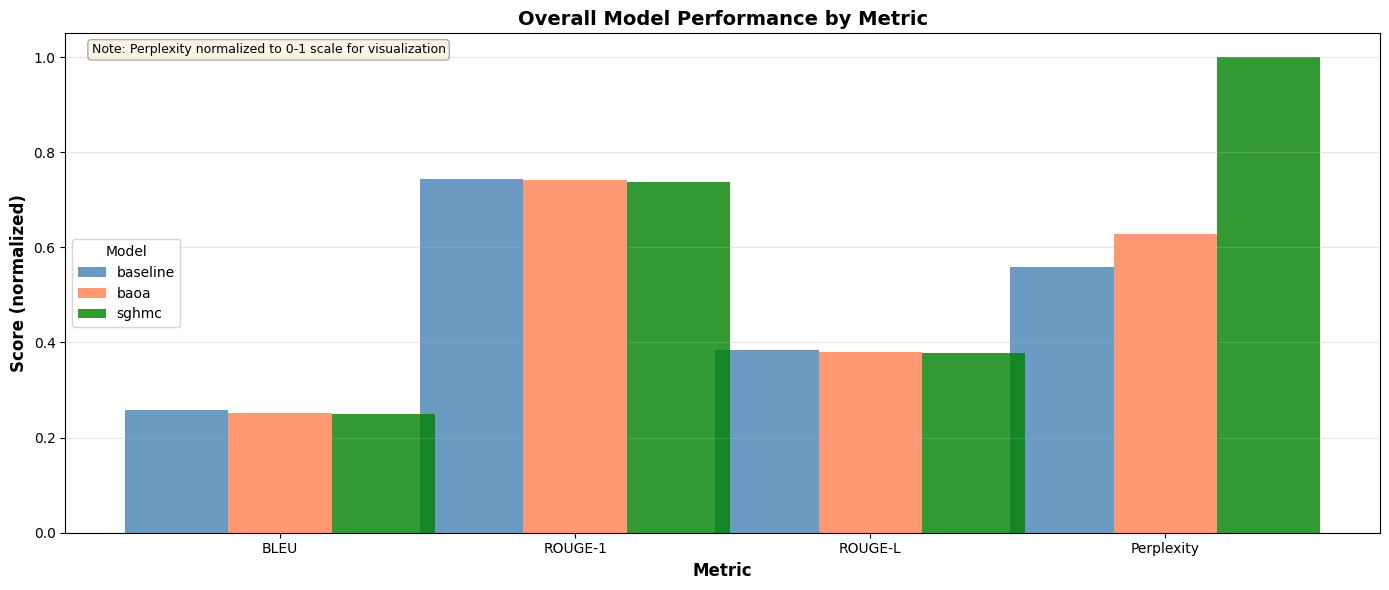

Model comparison barplot created successfully


In [78]:
# Create single barplot grouped by metric, colored by model
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Extract data for plotting
models = list(model_stats.keys())
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L', 'Perplexity']

# Prepare data for overall metrics
data_by_metric = []
for metric in metrics:
    for model in models:
        if model_stats[model]['overall']:
            stats = model_stats[model]['overall']
            if metric == 'BLEU':
                value = stats['bleu_mean']
            elif metric == 'ROUGE-1':
                value = stats['rouge1_mean']
            elif metric == 'ROUGE-L':
                value = stats['rougeL_mean']
            elif metric == 'Perplexity':
                value = stats['perplexity_mean']
            
            data_by_metric.append({
                'metric': metric,
                'model': model,
                'value': value
            })

# Set up positions for grouped bars
x = np.arange(len(metrics))
width = 0.35
colors = ['steelblue', 'coral', 'green', 'orange', 'purple', 'brown']
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models)}

# Plot bars grouped by metric
for i, model in enumerate(models):
    model_data = [d['value'] for d in data_by_metric if d['model'] == model]
    
    # Normalize perplexity to 0-1 scale for visualization (divide by max perplexity)
    # Keep BLEU and ROUGE as is
    normalized_values = []
    for idx, metric in enumerate(metrics):
        if metric == 'Perplexity':
            # Scale perplexity to 0-1 range (inverse and normalize)
            max_perplexity = max([d['value'] for d in data_by_metric if d['metric'] == 'Perplexity'])
            normalized_values.append(model_data[idx] / max_perplexity)
        else:
            normalized_values.append(model_data[idx])
    
    offset = width * (i - len(models)/2 + 0.5)
    ax.bar(x + offset, normalized_values, width, label=model, color=model_colors[model], alpha=0.8)

ax.set_xlabel('Metric', fontweight='bold', fontsize=12)
ax.set_ylabel('Score (normalized)', fontweight='bold', fontsize=12)
ax.set_title('Overall Model Performance by Metric', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Model')
ax.grid(axis='y', alpha=0.3)

# Add note about perplexity normalization
ax.text(0.02, 0.98, 'Note: Perplexity normalized to 0-1 scale for visualization', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save figure
output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "model_comparison_overall.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'model_comparison_overall.png'}")

plt.show()

print("Model comparison barplot created successfully")

Saved plot to evaluation_results\model_comparison_train_val_difference.png


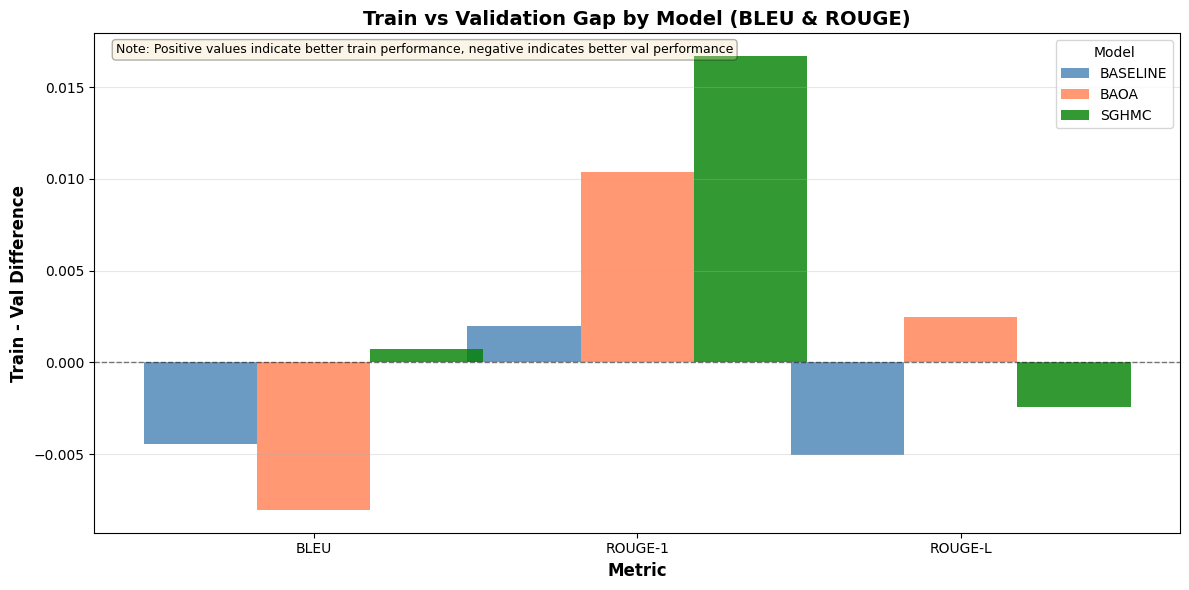

Train - Val difference barplot created successfully


In [80]:
# Create single plot showing train - val difference for both models (excluding Perplexity)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

models = list(model_stats.keys())
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L']  # Removed Perplexity and ROUGE-2
colors = ['steelblue', 'coral', 'green', 'orange', 'purple', 'brown']
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models)}

# Calculate train - val differences for each model
model_differences = {}
for model in models:
    differences = []
    
    for metric in metrics:
        train_val = None
        val_val = None
        
        # Get train value
        if model_stats[model]['train']:
            stats = model_stats[model]['train']
            if metric == 'BLEU':
                train_val = stats['bleu_mean']
            elif metric == 'ROUGE-1':
                train_val = stats['rouge1_mean']
            elif metric == 'ROUGE-L':
                train_val = stats['rougeL_mean']
        
        # Get val value
        if model_stats[model]['val']:
            stats = model_stats[model]['val']
            if metric == 'BLEU':
                val_val = stats['bleu_mean']
            elif metric == 'ROUGE-1':
                val_val = stats['rouge1_mean']
            elif metric == 'ROUGE-L':
                val_val = stats['rougeL_mean']
        
        # Calculate difference (train - val)
        if train_val is not None and val_val is not None:
            differences.append(train_val - val_val)
        else:
            differences.append(0)
    
    model_differences[model] = differences

# Set up positions for grouped bars
x = np.arange(len(metrics))
width = 0.35

# Plot bars for each model
for i, model in enumerate(models):
    offset = width * (i - len(models)/2 + 0.5)
    ax.bar(x + offset, model_differences[model], width, 
           label=model.upper(), color=model_colors[model], alpha=0.8)

ax.set_xlabel('Metric', fontweight='bold', fontsize=12)
ax.set_ylabel('Train - Val Difference', fontweight='bold', fontsize=12)
ax.set_title('Train vs Validation Gap by Model (BLEU & ROUGE)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(title='Model')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# Add note
ax.text(0.02, 0.98, 'Note: Positive values indicate better train performance, negative indicates better val performance', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "model_comparison_train_val_difference.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'model_comparison_train_val_difference.png'}")

plt.show()

print("Train - Val difference barplot created successfully")

Saved plot to evaluation_results\perplexity_train_val_difference.png


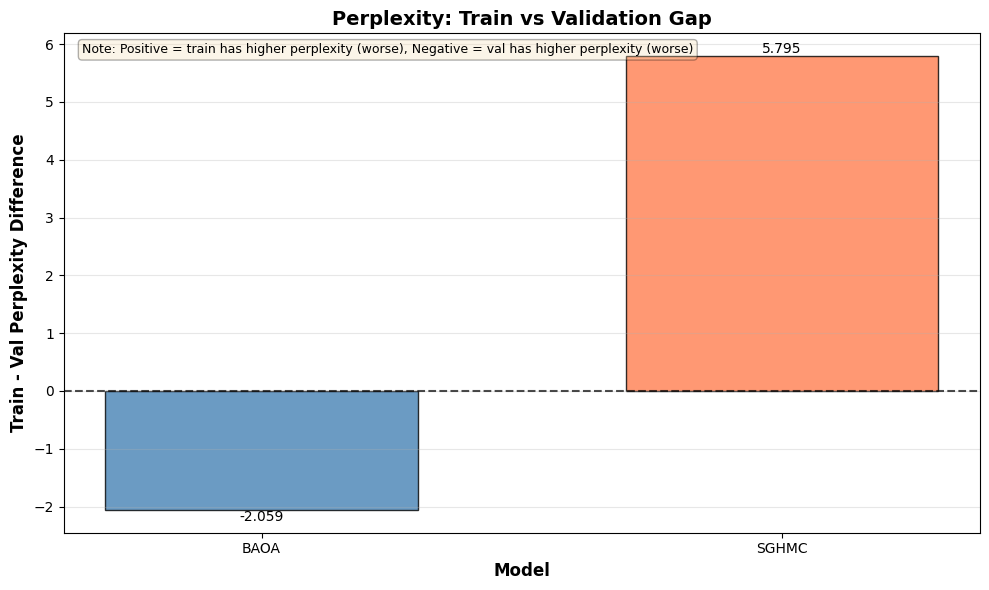

Perplexity train-val difference plot created successfully


In [52]:
# Create separate plot for Perplexity train-val difference
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Extract perplexity differences
perplexity_differences = {}
for model in models:
    train_perplexity = None
    val_perplexity = None
    
    if model_stats[model]['train']:
        train_perplexity = model_stats[model]['train']['perplexity_mean']
    
    if model_stats[model]['val']:
        val_perplexity = model_stats[model]['val']['perplexity_mean']
    
    if train_perplexity is not None and val_perplexity is not None:
        perplexity_differences[model] = train_perplexity - val_perplexity

# Set up positions
x = np.arange(len(models))
width = 0.6

# Plot bars
colors_list = [model_colors[model] for model in models]
bars = ax.bar(x, [perplexity_differences[model] for model in models], 
              width, color=colors_list, alpha=0.8, edgecolor='black')

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Train - Val Perplexity Difference', fontweight='bold', fontsize=12)
ax.set_title('Perplexity: Train vs Validation Gap', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models])
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (model, bar) in enumerate(zip(models, bars)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Add note
ax.text(0.02, 0.98, 'Note: Positive = train has higher perplexity (worse), Negative = val has higher perplexity (worse)', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "perplexity_train_val_difference.png", dpi=300, bbox_inches='tight')
print(f"Saved plot to {output_dir / 'perplexity_train_val_difference.png'}")

plt.show()

print("Perplexity train-val difference plot created successfully")

In [39]:
# save to csv files
output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)
overall_csv_path = output_dir / "overall_results.csv"
train_csv_path = output_dir / "train_results.csv"
val_csv_path = output_dir / "val_results.csv"

## Visualize Results

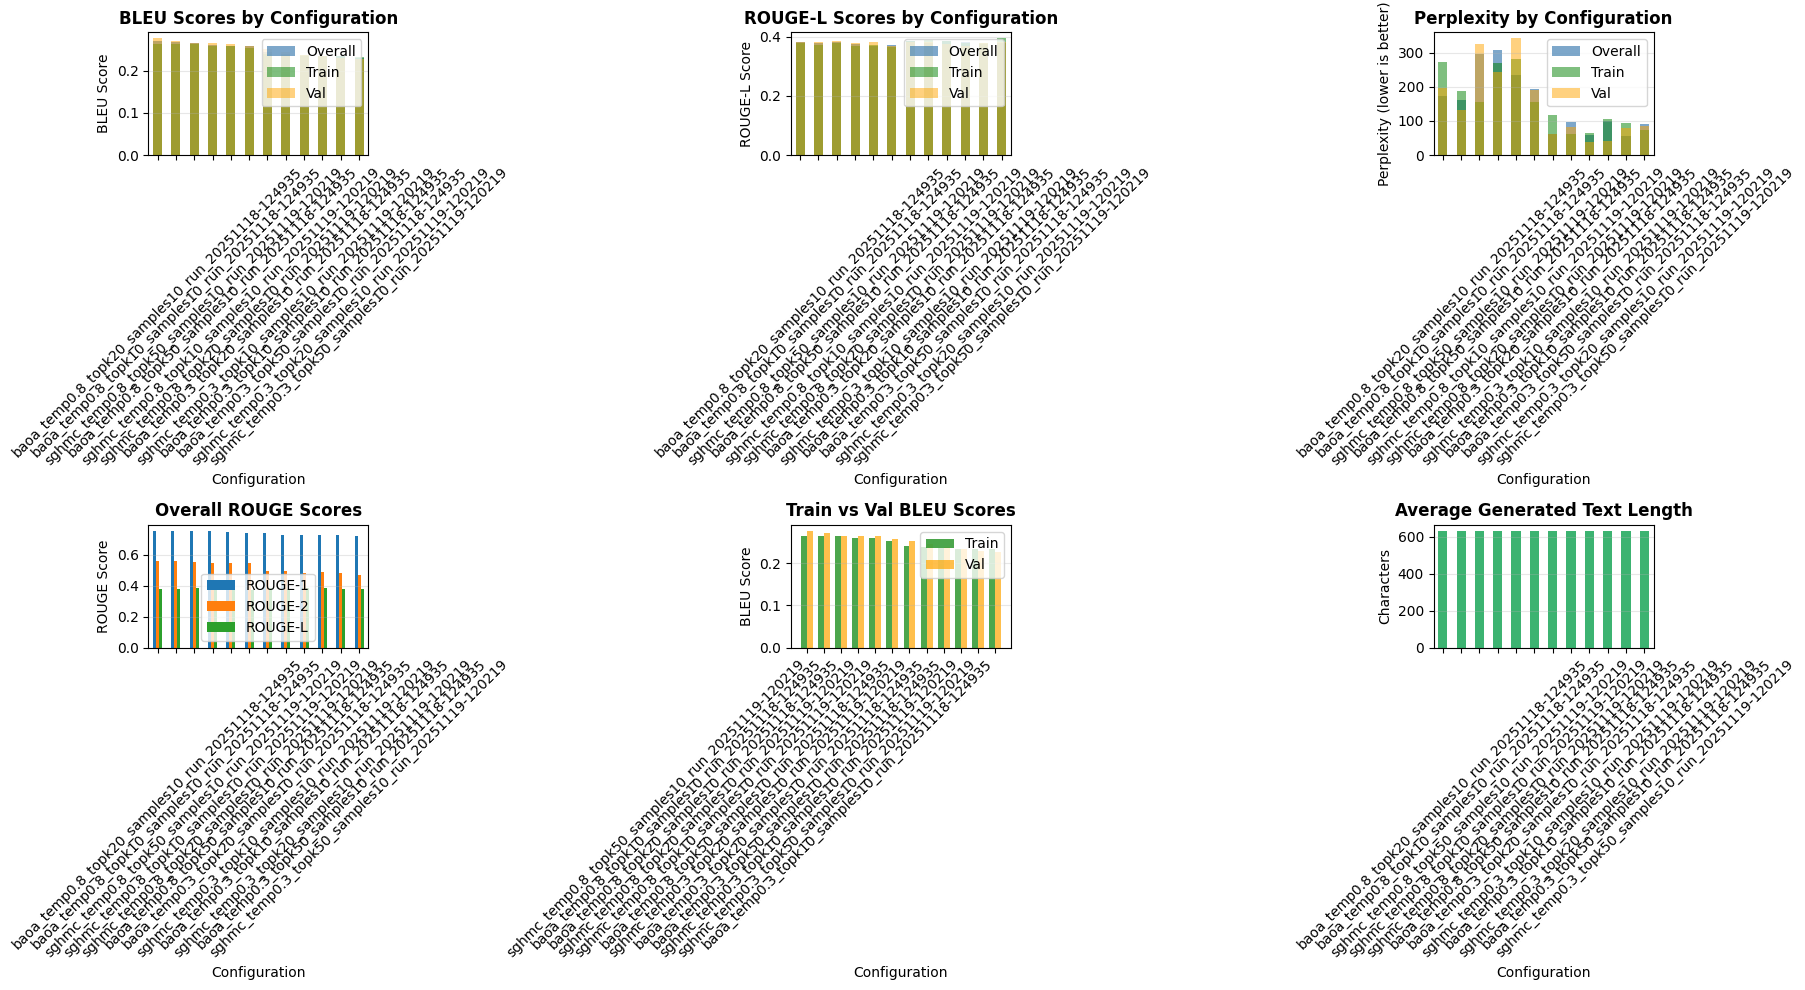

Visualizations complete


In [40]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: BLEU scores comparison (Overall, Train, Val)
ax1 = axes[0, 0]
if not df_overall.empty:
    df_overall['bleu'].plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7, label='Overall')
if not df_train.empty:
    df_train['bleu'].plot(kind='bar', ax=ax1, color='green', alpha=0.5, label='Train')
if not df_val.empty:
    df_val['bleu'].plot(kind='bar', ax=ax1, color='orange', alpha=0.5, label='Val')
ax1.set_title('BLEU Scores by Configuration', fontsize=12, fontweight='bold')
ax1.set_ylabel('BLEU Score')
ax1.set_xlabel('Configuration')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: ROUGE-L comparison
ax2 = axes[0, 1]
if not df_overall.empty:
    df_overall['rougeL'].plot(kind='bar', ax=ax2, color='steelblue', alpha=0.7, label='Overall')
if not df_train.empty:
    df_train['rougeL'].plot(kind='bar', ax=ax2, color='green', alpha=0.5, label='Train')
if not df_val.empty:
    df_val['rougeL'].plot(kind='bar', ax=ax2, color='orange', alpha=0.5, label='Val')
ax2.set_title('ROUGE-L Scores by Configuration', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROUGE-L Score')
ax2.set_xlabel('Configuration')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Perplexity comparison
ax3 = axes[0, 2]
if not df_overall.empty:
    df_overall['perplexity'].plot(kind='bar', ax=ax3, color='steelblue', alpha=0.7, label='Overall')
if not df_train.empty:
    df_train['perplexity'].plot(kind='bar', ax=ax3, color='green', alpha=0.5, label='Train')
if not df_val.empty:
    df_val['perplexity'].plot(kind='bar', ax=ax3, color='orange', alpha=0.5, label='Val')
ax3.set_title('Perplexity by Configuration', fontsize=12, fontweight='bold')
ax3.set_ylabel('Perplexity (lower is better)')
ax3.set_xlabel('Configuration')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Overall ROUGE scores (1, 2, L)
ax4 = axes[1, 0]
if not df_overall.empty:
    df_overall[['rouge1', 'rouge2', 'rougeL']].plot(kind='bar', ax=ax4)
    ax4.set_title('Overall ROUGE Scores', fontsize=12, fontweight='bold')
    ax4.set_ylabel('ROUGE Score')
    ax4.set_xlabel('Configuration')
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    ax4.grid(axis='y', alpha=0.3)

# Plot 5: Train vs Val BLEU comparison side-by-side
ax5 = axes[1, 1]
if not df_train.empty and not df_val.empty:
    x = np.arange(len(df_train))
    width = 0.35
    ax5.bar(x - width/2, df_train['bleu'], width, label='Train', color='green', alpha=0.7)
    ax5.bar(x + width/2, df_val['bleu'], width, label='Val', color='orange', alpha=0.7)
    ax5.set_title('Train vs Val BLEU Scores', fontsize=12, fontweight='bold')
    ax5.set_ylabel('BLEU Score')
    ax5.set_xlabel('Configuration')
    ax5.set_xticks(x)
    ax5.set_xticklabels(df_train.index, rotation=45, ha='right')
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)

# Plot 6: Average text length
ax6 = axes[1, 2]
if not df_overall.empty:
    df_overall['avg_text_length'].plot(kind='bar', ax=ax6, color='mediumseagreen')
    ax6.set_title('Average Generated Text Length', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Characters')
    ax6.set_xlabel('Configuration')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations complete")


## Save Results to JSON

In [122]:
from datetime import datetime

# Save results to JSON file
output_path = Path("llm_results/evaluation_metrics_results.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

# Count total samples across all subsets
total_overall = sum(r['overall']['num_samples'] for r in results_summary.values() if r.get('overall'))
total_train = sum(r['train']['num_samples'] for r in results_summary.values() if r.get('train'))
total_val = sum(r['val']['num_samples'] for r in results_summary.values() if r.get('val'))

# Convert results to serializable format
serializable_results = {}
for config_key, config_data in results_summary.items():
    serializable_results[config_key] = {
        'model_path': str(config_data['model_path']),
        'temperature': float(config_data['temperature']) if config_data['temperature'] != 'unknown' else 'unknown',
        'top_k': int(config_data['top_k']) if config_data['top_k'] != 'unknown' else 'unknown',
        'overall': config_data['overall'],
        'train': config_data['train'],
        'val': config_data['val']
    }

# Create output data with metadata
output_data = {
    'evaluation_timestamp': datetime.now().isoformat(),
    'num_configurations': len(results_summary),
    'total_samples': {
        'overall': total_overall,
        'train': total_train,
        'val': total_val
    },
    'metrics': serializable_results
}

with open(output_path, 'w') as f:
    json.dump(output_data, f, indent=2, default=str)

print(f"✓ Results saved to: {output_path}")
print(f"  Configurations: {output_data['num_configurations']}")
print(f"  Total samples - Overall: {total_overall}, Train: {total_train}, Val: {total_val}")


✓ Results saved to: llm_results\evaluation_metrics_results.json
  Configurations: 2
  Total samples - Overall: 4, Train: 2, Val: 2


## Summary Statistics

In [123]:
print("="*100)
print("SUMMARY STATISTICS")
print("="*100)

# Overall Statistics
if not df_overall.empty:
    print("\n### OVERALL METRICS ###")
    print(f"\nBest BLEU Score:")
    best_bleu_config = df_overall['bleu'].idxmax()
    print(f"  Configuration: {best_bleu_config}")
    print(f"  BLEU: {df_overall.loc[best_bleu_config, 'bleu']:.4f}")
    print(f"  ROUGE-1: {df_overall.loc[best_bleu_config, 'rouge1']:.4f}")
    print(f"  ROUGE-L: {df_overall.loc[best_bleu_config, 'rougeL']:.4f}")
    print(f"  Perplexity: {df_overall.loc[best_bleu_config, 'perplexity']:.2f}")

    print(f"\nBest ROUGE-L Score:")
    best_rouge_config = df_overall['rougeL'].idxmax()
    print(f"  Configuration: {best_rouge_config}")
    print(f"  ROUGE-L: {df_overall.loc[best_rouge_config, 'rougeL']:.4f}")
    print(f"  BLEU: {df_overall.loc[best_rouge_config, 'bleu']:.4f}")
    print(f"  Perplexity: {df_overall.loc[best_rouge_config, 'perplexity']:.2f}")

    print(f"\nLowest Perplexity:")
    best_ppl_config = df_overall['perplexity'].idxmin()
    print(f"  Configuration: {best_ppl_config}")
    print(f"  Perplexity: {df_overall.loc[best_ppl_config, 'perplexity']:.2f}")
    print(f"  BLEU: {df_overall.loc[best_ppl_config, 'bleu']:.4f}")
    print(f"  ROUGE-L: {df_overall.loc[best_ppl_config, 'rougeL']:.4f}")

    print(f"\nOverall Statistics:")
    print(f"  Mean BLEU: {df_overall['bleu'].mean():.4f} ± {df_overall['bleu'].std():.4f}")
    print(f"  Mean ROUGE-1: {df_overall['rouge1'].mean():.4f} ± {df_overall['rouge1'].std():.4f}")
    print(f"  Mean ROUGE-L: {df_overall['rougeL'].mean():.4f} ± {df_overall['rougeL'].std():.4f}")
    print(f"  Mean Perplexity: {df_overall['perplexity'].mean():.2f} ± {df_overall['perplexity'].std():.2f}")

# Train Statistics
if not df_train.empty:
    print("\n" + "="*100)
    print("### TRAIN PROMPTS METRICS ###")
    print(f"\nBest BLEU Score:")
    best_bleu_train = df_train['bleu'].idxmax()
    print(f"  Configuration: {best_bleu_train}")
    print(f"  BLEU: {df_train.loc[best_bleu_train, 'bleu']:.4f}")
    print(f"  ROUGE-L: {df_train.loc[best_bleu_train, 'rougeL']:.4f}")
    print(f"  Perplexity: {df_train.loc[best_bleu_train, 'perplexity']:.2f}")

    print(f"\nTrain Statistics:")
    print(f"  Mean BLEU: {df_train['bleu'].mean():.4f} ± {df_train['bleu'].std():.4f}")
    print(f"  Mean ROUGE-L: {df_train['rougeL'].mean():.4f} ± {df_train['rougeL'].std():.4f}")
    print(f"  Mean Perplexity: {df_train['perplexity'].mean():.2f} ± {df_train['perplexity'].std():.2f}")

# Val Statistics
if not df_val.empty:
    print("\n" + "="*100)
    print("### VALIDATION PROMPTS METRICS ###")
    print(f"\nBest BLEU Score:")
    best_bleu_val = df_val['bleu'].idxmax()
    print(f"  Configuration: {best_bleu_val}")
    print(f"  BLEU: {df_val.loc[best_bleu_val, 'bleu']:.4f}")
    print(f"  ROUGE-L: {df_val.loc[best_bleu_val, 'rougeL']:.4f}")
    print(f"  Perplexity: {df_val.loc[best_bleu_val, 'perplexity']:.2f}")

    print(f"\nValidation Statistics:")
    print(f"  Mean BLEU: {df_val['bleu'].mean():.4f} ± {df_val['bleu'].std():.4f}")
    print(f"  Mean ROUGE-L: {df_val['rougeL'].mean():.4f} ± {df_val['rougeL'].std():.4f}")
    print(f"  Mean Perplexity: {df_val['perplexity'].mean():.2f} ± {df_val['perplexity'].std():.2f}")

# Comparison
if not df_train.empty and not df_val.empty:
    print("\n" + "="*100)
    print("### TRAIN vs VAL COMPARISON ###")
    print(f"\nBLEU Score Difference (Train - Val):")
    for config in df_train.index:
        if config in df_val.index:
            diff = df_train.loc[config, 'bleu'] - df_val.loc[config, 'bleu']
            print(f"  {config}: {diff:+.4f}")
    
    print(f"\nPerplexity Difference (Train - Val):")
    for config in df_train.index:
        if config in df_val.index:
            diff = df_train.loc[config, 'perplexity'] - df_val.loc[config, 'perplexity']
            print(f"  {config}: {diff:+.2f}")

print("\n" + "="*100)


SUMMARY STATISTICS

### OVERALL METRICS ###

Best BLEU Score:
  Configuration: sghmc_temp0.3_topk10_samples1_run_20251119-120219
  BLEU: 0.0610
  ROUGE-1: 0.2441
  ROUGE-L: 0.1854
  Perplexity: 104.40

Best ROUGE-L Score:
  Configuration: baoa_temp0.3_topk10_samples1_run_20251118-124935
  ROUGE-L: 0.1910
  BLEU: 0.0555
  Perplexity: 55.51

Lowest Perplexity:
  Configuration: baoa_temp0.3_topk10_samples1_run_20251118-124935
  Perplexity: 55.51
  BLEU: 0.0555
  ROUGE-L: 0.1910

Overall Statistics:
  Mean BLEU: 0.0583 ± 0.0039
  Mean ROUGE-1: 0.2489 ± 0.0068
  Mean ROUGE-L: 0.1882 ± 0.0040
  Mean Perplexity: 79.96 ± 34.57

### TRAIN PROMPTS METRICS ###

Best BLEU Score:
  Configuration: sghmc_temp0.3_topk10_samples1_run_20251119-120219
  BLEU: 0.0630
  ROUGE-L: 0.2087
  Perplexity: 46.23

Train Statistics:
  Mean BLEU: 0.0610 ± 0.0028
  Mean ROUGE-L: 0.2019 ± 0.0096
  Mean Perplexity: 51.27 ± 7.12

### VALIDATION PROMPTS METRICS ###

Best BLEU Score:
  Configuration: sghmc_temp0.3_topk10_